# Make a Flamingo Euclid RR2 catalog/map

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.cosmology import *
from LSS_forward_model.lensing import *
from LSS_forward_model.maps import *
from LSS_forward_model.halos import *
from LSS_forward_model.tsz import *
from LSS_forward_model.theory import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass
import frogress
from astropy.cosmology import wCDM

# Setup forward model - config

In [3]:
# Setup     ********************************
path_simulation = '/global/cfs/cdirs/m5099/Flamingo_nu_corrected/'
# general settings ----------------------------------
nside_maps = 1024

# nuisance parameters ------------------------------
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] =  [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0


# Baryonification settings ------------------------------------------------
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1,
    "mass_cut": 13.,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_default_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}

SC_corrections = np.load('../Data/SC_RR2_fit_nov6.npy',allow_pickle =True).item()



# Read cosmology & setup params

In [5]:
# Flamingo Cosmology ****************************************
sims_parameters = {'Omega_b': 0.0486	,
 'Omega_nu': 1.39 * 0.001,
 'Omega_m': 0.306	,
 'Omega_cdm': 0.25601,
 'h':  0.681,
 'w0': -1.0,
 'wa': 0.0,
 'As': 2.099e-09,
 'n_s': 0.967,
 'sigma_8': 0.807,
 'm_nu': 0.060,
 'n_nu': 1,
 'dBoxSize Mpc/h': 1000*0.681}



cosmo_bundle = make_cosmo_bundle(sims_parameters)
sims_parameters.update(nuisance_parameters)
    

z_edges = np.linspace(0,3.0,61)
d_edges = redshift_to_distance(z_edges,cosmo_bundle)*sims_parameters['h']

d_edges = np.hstack([d_edges,redshift_to_distance(np.arange(z_edges[-1],6.,0.12)[1:],cosmo_bundle)*sims_parameters['h']])
z_edges = np.hstack([z_edges,np.arange(z_edges[-1],6.,0.12)[1:]])
shells_info = make_shells_info_from_edges(z_edges, d_edges)



# setup n(z)

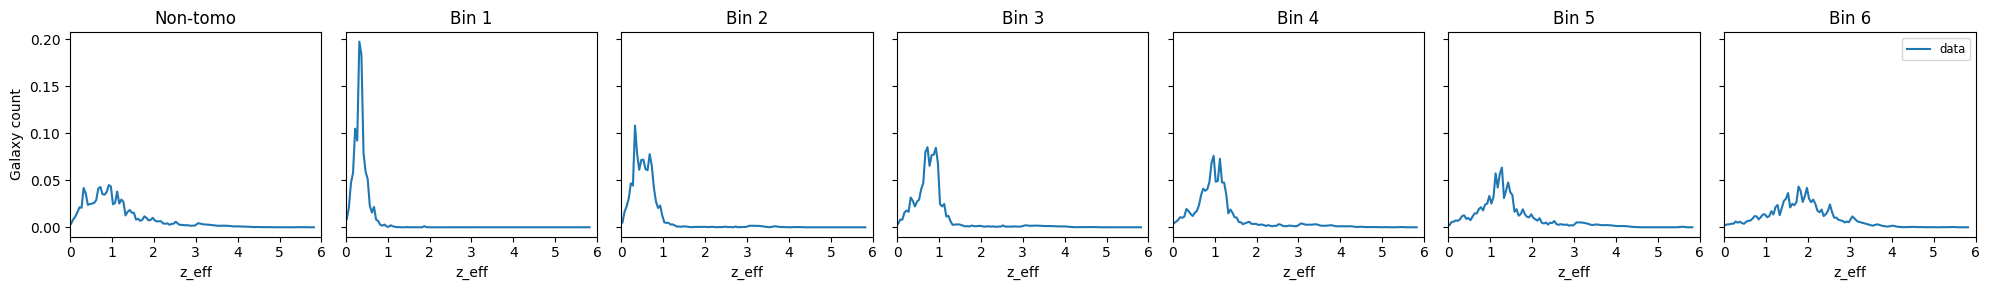

In [6]:
nz_RR2 = np.load('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z_rebinned.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)

# Plot -----------------------------------------------------------------
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for i, ax in enumerate(axes):
    ax.plot(zeff_glass, ngal_glass[i], label="data")
    ax.set_xlim(0, 6)
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
axes[-1].legend(loc="upper right", fontsize="small")
plt.tight_layout(); plt.show()


# Baryonify original Flamingo (optional)

In [6]:
type_  = 'DMO_FIDUCIAL'
path = "/pscratch/sd/j/junzhez/flamingo/output_flamingo_reduction_tsz_corrected/{0}/lightcone0_shells_nside1024/".format(type_)
path_catalog = '/global/cfs/cdirs/m5099/Flamingo/data/L1000N1800_DMO_FIDUCIAL_fof_halo_cat_marco_2.fits'
dens_path = os.path.join(path_simulation, f"delta_b_{nside_maps}.npy")

baryons1 = copy.deepcopy(baryons)
baryons1["enabled"] = 'True'
bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)  


# load particle counts ------------------
n_particles = []
for i in range(len(z_edges)-1):
    try:
        m = h5.File(path+'shell_{0}.hdf5'.format(i))
        mass = np.array(m['TotalMass'])
        n_particles.append(mass)
    except:
        pass


# load catalog
halos_flamingo = load_Flamingo_halo_catalog(path_catalog,sims_parameters, cosmo_bundle, type_cat = 'fof',halo_catalog_log10mass_cut = baryons['mass_cut'], max_z_halo_catalog = baryons['max_z_halo_catalog'])

# baryonify Flamingo ------------------------
make_tsz_and_baryonified_density(
                path_simulation,
                sims_parameters,
                cosmo_bundle['cosmo_pyccl'],
                halos_flamingo,
                bpar,
                nside_maps,
                shells_info,
                dens_path,
                '',
                baryons['do_tSZ'],
                shells,
                cosmo_bundle['pars_camb'],
                baryons['mass_cut'],
                particles = n_particles
            )

density = np.load(dens_path,allow_pickle=True)
fields_baryo = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields_baryo['density'] = density


100.0% | [##########] | Progress: 84 / 84 | Time: 1min3s | ETA: --             

# load density shells and compute shear field

In [7]:
type_  = 'DMO_FIDUCIAL'
#path = "/pscratch/sd/j/junzhez/flamingo/flamingo_reduced_tsz/{0}/lightcone0_shells_nside1024/".format(type_)
path = "/pscratch/sd/j/junzhez/flamingo/output_flamingo_reduction_tsz_corrected/{0}/lightcone0_shells_nside1024/".format(type_)

# new maps -------
path = "/global/cfs/cdirs/m5099/Flamingo_nu_corrected/data/{0}/lightcone0_shells_nside1024/".format(type_)

# load density -------------------------
# Assuming you start from redshift 0 and you go higher z
density = []
for i in range(len(z_edges)-1):
    try:
        m = h5.File(path+'shell_{0}.hdf5'.format(i))
        mass = np.array(m['TotalMass'])
        d = mass/np.mean(mass)-1.
        density.append(d)
    except:
        pass
density = np.array(density)


#add high redshift shells --------------
if len(shells)>len(density):
    missing_shells = []
    for i in range(len(density),len(shells)):
        missing_shells.append(shells[i])
    density_to_be_added = add_shells(cosmo_bundle['pars_camb'],nside_maps = nside_maps,missing_shells = missing_shells)
density = np.vstack([density,density_to_be_added])

# shear field ---------------------------
fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density

100.0% | [##########] | Progress: 84 / 84 | Time: 1min6s | ETA: --             

# Theory checks

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
100.0% | [##########] | Progress: 4000 / 4000 | Time: 2.9s | ETA: --           

/tmp/ipykernel_1531800/2265158576.py:27: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))


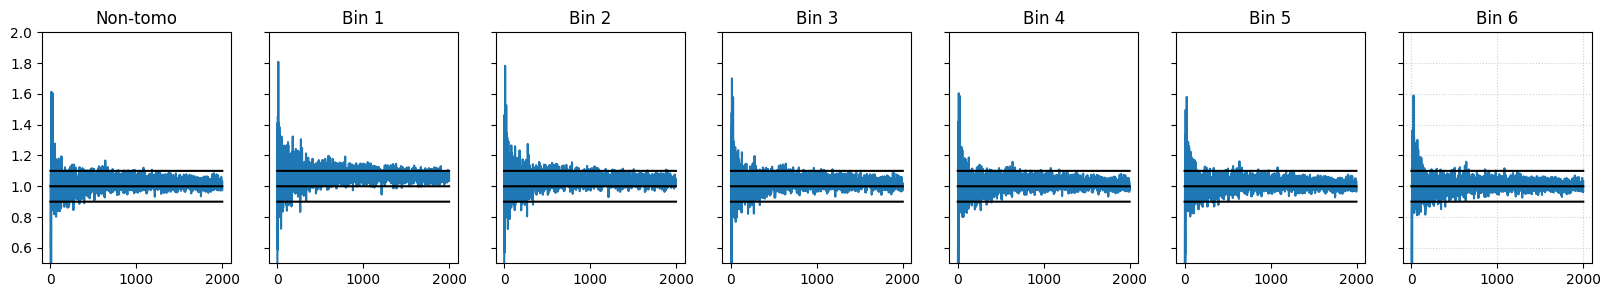

In [8]:
theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="mead")  # "euclidemu" | "mead" | "halofit"
theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)
Cgg = theory.cl_gg(nonlinear=True)


kappa_tomo = integrate_field(ngal_glass, fields["kappa"])
Cls = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])

try:
    kappa_tomo_baryo = integrate_field(ngal_glass, fields_baryo["kappa"])
    Cls_baryo = np.array([(hp.anafast(kappa_tomo_baryo[tomo,:])) for tomo in range(len(ngal_glass))])

except:
    pass


# choose a safe ℓ-range common to all arrays
ell_max = 2000
pix = hp.pixwin(nside_maps)[:ell_max]
ells = np.arange(ell_max)

mask_ell = ells >= 2  # avoid ℓ=0,1

fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    try:
        ax.plot(Cls_baryo[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    except:
        pass
    ax.plot(np.ones(ell_max),color = 'black')
    ax.plot(0.9*np.ones(ell_max),color = 'black')
    ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_ylim([0.5,2])
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)


# Make mocks/maps

In [ ]:
path_data_cats = '/global/cfs/cdirs/m5099/RR2/Euclid_cats.npy'
cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()
maps_Gower_WL,_ = make_WL_sample(ngal_glass, zeff_glass, cosmo_bundle, sims_parameters, nside_maps, fields, cats_Euclid, SC_corrections = SC_corrections, do_catalog = False, include_SC = True)

In [19]:
1

1

# Extensive tests baryonification

In [46]:
#- how much baryonification am I loosing at z > 1.5? [not much, mostly at z<1]

In [9]:
types = ['HYDRO_FIDUCIAL','DMO_FIDUCIAL']
path_base = "/pscratch/sd/j/junzhez/flamingo/output_flamingo_reduction_tsz_corrected/" # '/global/cfs/cdirs/m5099/Flamingo/data/'

cls_dict = dict()
for type_ in types:

    path = path_base+"/{0}/lightcone0_shells_nside1024/".format(type_)

    # load density -------------------------
    # Assuming you start from redshift 0 and you go higher z
    density = []
    for i in range(len(z_edges)-1):
        try:
            m = h5.File(path+'shell_{0}.hdf5'.format(i))
            mass = np.array(m['TotalMass'])
            d = mass/np.mean(mass)-1.
            density.append(d)
        except:
            pass
    density = np.array(density)
    
    
    #add high redshift shells --------------
    if len(shells)>len(density):
        missing_shells = []
        for i in range(len(density),len(shells)):
            missing_shells.append(shells[i])
        density_to_be_added = add_shells(cosmo_bundle['pars_camb'],nside_maps = nside_maps,missing_shells = missing_shells)
    density = np.vstack([density,density_to_be_added])


    fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=False, do_IA=False)
    kappa_tomo = integrate_field(ngal_glass, fields["kappa"])
    cls_dict[type_]  = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])


100.0% | [##########] | Progress: 84 / 84 | Time: 6.2s | ETA: --               

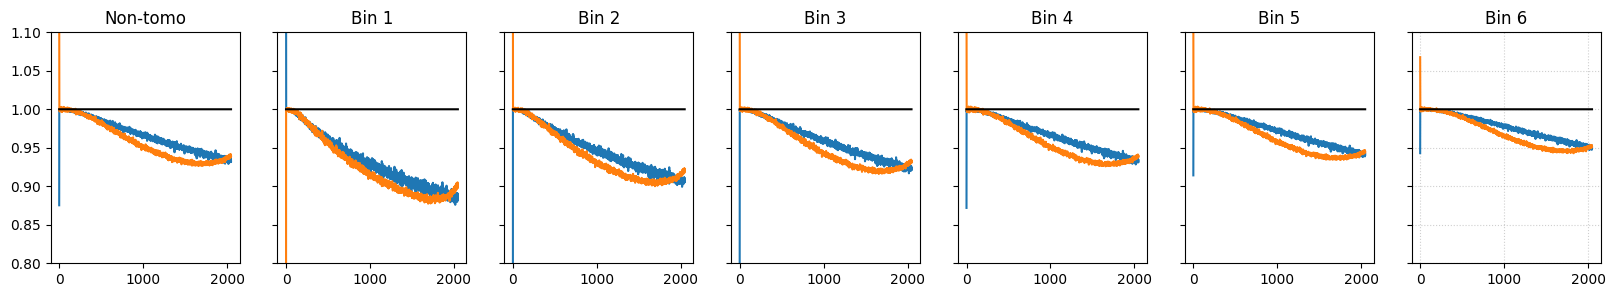

In [10]:
ratios = cls_dict['HYDRO_FIDUCIAL']/cls_dict['DMO_FIDUCIAL']

ell_max = 2048
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(ratios[tomo,:ell_max])
    ax.plot(Cls_baryo[tomo, :ell_max]/Cls[tomo, :ell_max])
    ax.plot(np.ones(ell_max),color = 'black')
    ax.set_ylim([0.8,1.1])
    #ax.plot(0.9*np.ones(ell_max),color = 'black')
    #ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)

In [11]:
path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/Flamingo_big/'
nside_maps = 1024

# nuisance parameters ------------------------------
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] =  [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0



sims_parameters, cosmo_bundle = read_sims_params(path_simulation)
sims_parameters.update(nuisance_parameters)
    
shells_info = recover_shell_info(path_simulation+'/z_values.txt', max_z=49)

nz_RR2 = np.load('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z_rebinned.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)



baryons = {
    "enabled": True,
    "max_z_halo_catalog": 1,
    "mass_cut": 13.,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_default_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}

bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)  


#save_halocatalog(shells_info, sims_parameters, max_redshift = 1.1, halo_snapshots_path = '' , catalog_path = 'halo_catalog.parquet',log10_mass_limit = None)

density, label_baryonification = load_and_baryonify_gower_st_shells(
    path_simulation,
    sims_parameters,
    cosmo_bundle,
    baryons,
    nside_maps,
    shells_info,
    shells,
    overwrite_baryonified_shells = False)


fields_baryo = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields_baryo['density'] = density
kappa_tomo_baryo = integrate_field(ngal_glass, fields_baryo["kappa"])
Cls_baryo_myf = np.array([(hp.anafast(kappa_tomo_baryo[tomo,:])) for tomo in range(len(ngal_glass))])

# density field ---------------------
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1,
    "mass_cut": 13.,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_default_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}
density_dmo, label_baryonification = load_and_baryonify_gower_st_shells(
    path_simulation,
    sims_parameters,
    cosmo_bundle,
    baryons,
    nside_maps,
    shells_info,
    shells)

# shear field ---------------------------
fields = compute_lensing_fields(density_dmo, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density_dmo

kappa_tomo = integrate_field(ngal_glass, fields["kappa"])
Cls_myf = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])


100.0% | [##########] | Progress: 100 / 100 | Time: 1min15s | ETA: --          

100.0% | [##########] | Progress: 4000 / 4000 | Time: 2.8s | ETA: --           

/tmp/ipykernel_482109/3456958050.py:15: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls_myf[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
/tmp/ipykernel_482109/3456958050.py:17: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls_baryo_myf[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))


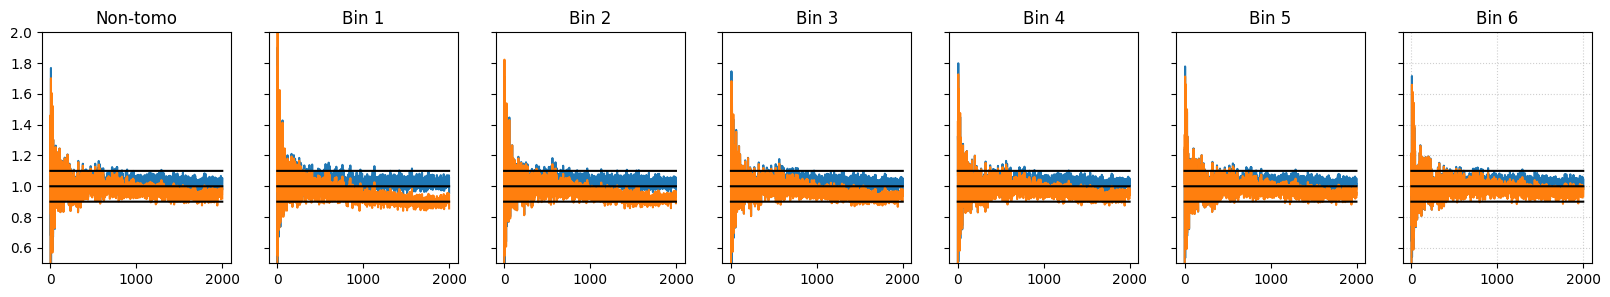

In [12]:
theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="mead")  # "euclidemu" | "mead" | "halofit"
theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)
Cgg = theory.cl_gg(nonlinear=True)

# choose a safe ℓ-range common to all arrays
ell_max = 2000
pix = hp.pixwin(nside_maps)[:ell_max]
ells = np.arange(ell_max)

mask_ell = ells >= 2  # avoid ℓ=0,1

fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(Cls_myf[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    try:
        ax.plot(Cls_baryo_myf[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    except:
        pass
    ax.plot(np.ones(ell_max),color = 'black')
    ax.plot(0.9*np.ones(ell_max),color = 'black')
    ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_ylim([0.5,2])
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)


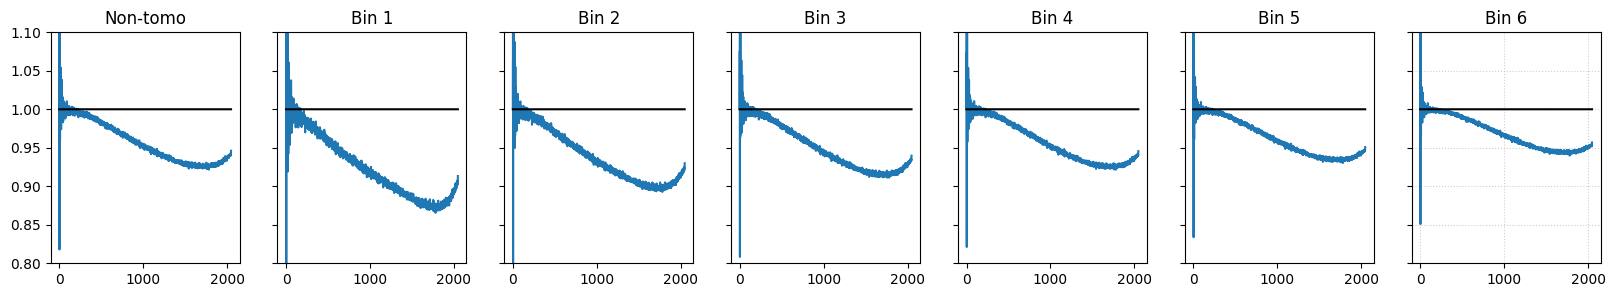

In [10]:
#ratios = cls_dict['HYDRO_FIDUCIAL']/cls_dict['DMO_FIDUCIAL']

ell_max = 2048
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
   # ax.plot(ratios[tomo,:ell_max])
    #ax.plot(Cls_baryo[tomo, :ell_max]/Cls[tomo, :ell_max])
    ax.plot(Cls_baryo_myf[tomo, :ell_max]/Cls_myf[tomo, :ell_max])
    ax.plot(np.ones(ell_max),color = 'black')
    ax.set_ylim([0.8,1.1])
    #ax.plot(0.9*np.ones(ell_max),color = 'black')
    #ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)

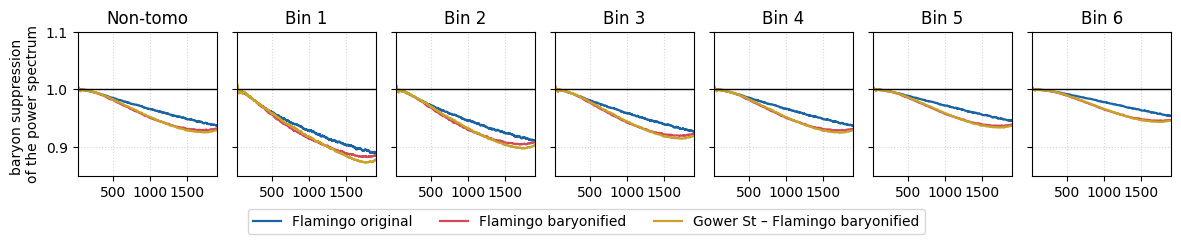

In [29]:
def smooth(y, w=25):
    return np.convolve(y, np.ones(w)/w, mode='same')

ell_max = 2048
ells = np.arange(ell_max)

colors = {
    "orig": "#1b63a3",       # deep blue
    "flam_bary": "#d1495b",  # warm red
    "myf": "#c9a227"         # muted gold
}

fig, axes = plt.subplots(1, 7, figsize=(12, 2.2), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]

for tomo, ax in enumerate(axes):
    ax.plot(ells, smooth(ratios[tomo, :ell_max]), 
            label="Flamingo original", color=colors["orig"], lw=1.6)

    ax.plot(ells, smooth(Cls_baryo[tomo, :ell_max] / Cls[tomo, :ell_max]), 
            label="Flamingo baryonified", color=colors["flam_bary"], lw=1.6)

    ax.plot(ells, smooth(Cls_baryo_myf[tomo, :ell_max] / Cls_myf[tomo, :ell_max]), 
            label="Gower St – Flamingo baryonified", color=colors["myf"], lw=1.6)

    ax.axhline(1.0, color="black", lw=1)
    ax.set_ylim(0.85, 1.1)
    ax.set_xlim(30, 1900)
    ax.set_title(titles[tomo])
    ax.grid(True, which="both", ls=":", alpha=0.5)

axes[0].set_ylabel("baryon suppression \nof the power spectrum")
plt.tight_layout()

# Optional: legend outside
fig.legend(*axes[0].get_legend_handles_labels(),
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.12),
           ncol=3)

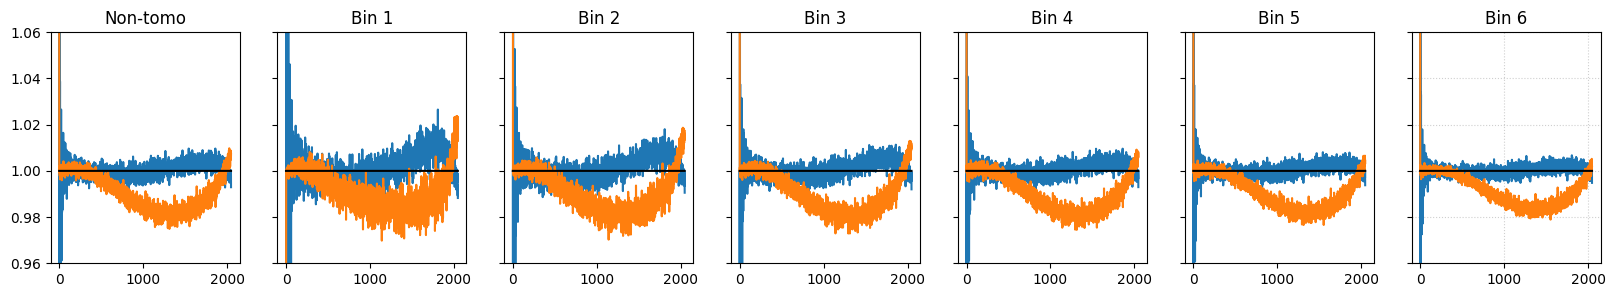

In [28]:
ell_max = 2048
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
   # ax.plot(ratios[tomo,:ell_max])
    ax.plot(Cls_baryo[tomo, :ell_max]/Cls[tomo, :ell_max]/(Cls_baryo_myf[tomo, :ell_max]/Cls_myf[tomo, :ell_max]))
    ax.plot(Cls_baryo[tomo, :ell_max]/Cls[tomo, :ell_max]/(ratios[tomo, :ell_max]))
    
    # ax.plot(Cls_baryo_myf[tomo, :ell_max]/Cls_myf[tomo, :ell_max])
    ax.plot(np.ones(ell_max),color = 'black')
    ax.set_ylim([0.96,1.06])
    #ax.plot(0.9*np.ones(ell_max),color = 'black')
    #ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)

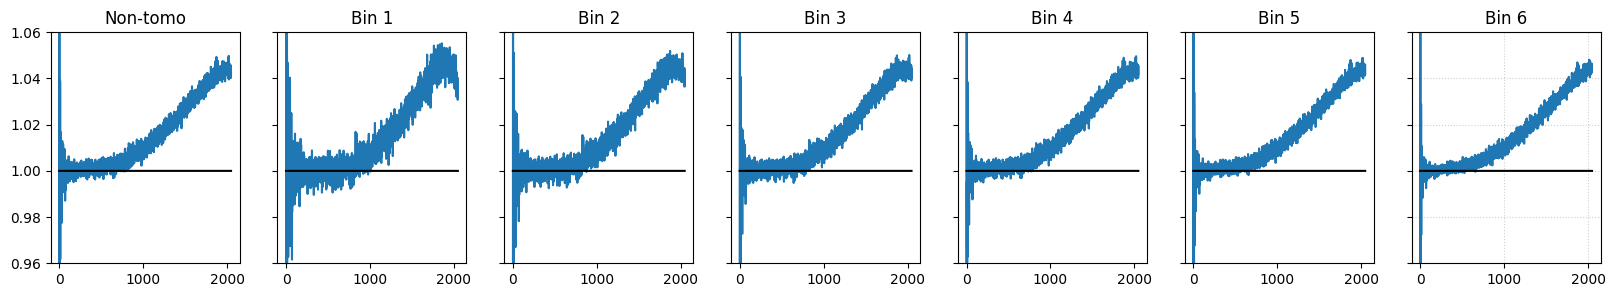

In [24]:
ell_max = 2048
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
   # ax.plot(ratios[tomo,:ell_max])
    ax.plot(Cls_baryo[tomo, :ell_max]/Cls[tomo, :ell_max]/(Cls_baryo_myf[tomo, :ell_max]/Cls_myf[tomo, :ell_max]))
   # ax.plot(Cls_baryo_myf[tomo, :ell_max]/Cls_myf[tomo, :ell_max])
    ax.plot(np.ones(ell_max),color = 'black')
    ax.set_ylim([0.96,1.06])
    #ax.plot(0.9*np.ones(ell_max),color = 'black')
    #ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)

# check halo mass function --

In [42]:
# Load Flamingo halo catalog ------
sims_parameters = {'Omega_b': 0.0486	,
 'Omega_nu': 1.39 * 0.001,
 'Omega_m': 0.306	,
 'Omega_cdm': 0.25601,
 'h':  0.681,
 'w0': -1.0,
 'wa': 0.0,
 'As': 2.099e-09,
 'n_s': 0.967,
 'sigma_8': 0.807,
 'm_nu': 0.060,
 'n_nu': 1,
 'dBoxSize Mpc/h': 1000*0.681}

cosmo_bundle = make_cosmo_bundle(sims_parameters)
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1,
    "mass_cut": 13.,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_default_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}
path_catalog = '/global/cfs/cdirs/m5099/Flamingo/data/L1000N1800_DMO_FIDUCIAL_fof_halo_cat_marco_2.fits'

halos_flamingo = load_Flamingo_halo_catalog(path_catalog,sims_parameters, cosmo_bundle, type_cat = 'fof',halo_catalog_log10mass_cut = baryons['mass_cut'], max_z_halo_catalog = baryons['max_z_halo_catalog'])

# Load my sims halo catalog ------
path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/Flamingo_big/'
sims_parameters_, cosmo_bundle_ = read_sims_params(path_simulation)

halo_catalog_path = os.path.join(path_simulation, "halo_catalog.parquet")
halos_gower = load_halo_catalog(
                halo_catalog_path,
                cosmo_bundle_['colossus_params'],
                sims_parameters_,
                baryons['mass_cut'],
                no_calib = True,
            )

no calib


In [43]:
from colossus.cosmology import cosmology as cosmology_colossus
from colossus.lss import mass_function
from scipy.ndimage import gaussian_filter1d
cosmo_colossus = cosmology_colossus.setCosmology('myCosmo', cosmo_bundle['colossus_params'],de_model = 'w0wa', w0 = -1, wa = 0)
h = 0.681
min_ = np.array([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])#,1.0,1.1,1.2,1.3])
max_ = min_+0.1

In [44]:
params = {'flat': True, 'H0': 0.681*100, 'Om0':  0.306, 'Ob0': 0.0486, 'sigma8': 0.807 ,'ns': 	0.967, 'relspecies' : True}
cosmology_colossus.addCosmology('myCosmo', params)
cosmo_colossus = cosmology_colossus.setCosmology('myCosmo', params,de_model = 'w0', w0 = -1)
h = 0.681
mdef = 'fof'
dndm_model = 'bhattacharya11'
M_ratios_flamingo = []
M_ratios_Gower = []
z_mean_ = []
m_interp = dict()
for jp in frogress.bar(range(len(min_))):

    M_array_edges = np.logspace(13.0, 15.0, 30)
    M_cen = 0.5*(M_array_edges[1:] + M_array_edges[:-1])
    delta_M_array = M_array_edges[1:] - M_array_edges[:-1]
    
    mask = (halos_flamingo['z']>min_[jp]) &  (halos_flamingo['z']<max_[jp])
    mhalo_sim = (halos_flamingo['M'][mask])
    zhalo_sim = halos_flamingo['z'][mask]

    zmean = np.mean(zhalo_sim)
    z_mean_.append(zmean)
    zmin, zmax = np.min(zhalo_sim), np.max(zhalo_sim)

    
    Nm_all_sim, _ = np.histogram(mhalo_sim*(h), bins=M_array_edges)

    Rz1 = cosmo_colossus.comovingDistance(0, zmin)
    Rz2 = cosmo_colossus.comovingDistance(0, zmax)
    Vol = 4/3.*np.pi*(Rz2**3-Rz1**3)

    dndm_theory = (1/M_cen) * mass_function.massFunction(M_cen, zmean,
                                                  mdef=mdef, model=dndm_model,
                                                  q_out='dndlnM')

    Nm_all_theory = dndm_theory * delta_M_array * Vol
    y =  Nm_all_sim/Nm_all_theory
    ysmoothed = gaussian_filter1d(y, sigma=2)
    m_interp[zmean] = (ysmoothed) 
    M_ratios_flamingo.append(y)



    # ----------------
    mask = (halos_gower['z']>min_[jp]) &  (halos_gower['z']<max_[jp])
    mhalo_sim = (halos_gower['M'][mask])
    zhalo_sim = halos_gower['z'][mask]


    Nm_all_sim, _ = np.histogram(mhalo_sim*(h), bins=M_array_edges)

    Rz1 = cosmo_colossus.comovingDistance(0, zmin)
    Rz2 = cosmo_colossus.comovingDistance(0, zmax)
    Vol = 4/3.*np.pi*(Rz2**3-Rz1**3)

    dndm_theory = (1/M_cen) * mass_function.massFunction(M_cen, zmean,
                                                  mdef=mdef, model=dndm_model,
                                                  q_out='dndlnM')

    Nm_all_theory = dndm_theory * delta_M_array * Vol
    y =  Nm_all_sim/Nm_all_theory
    ysmoothed = gaussian_filter1d(y, sigma=2)
    m_interp[zmean] = (ysmoothed) 
    M_ratios_Gower.append(y)
    

100.0% | [##########] | Progress: 10 / 10 | Time: 3.0s | ETA: --               

100.0% | [##########] | Progress: 10 / 10 | Time: 0.0s | ETA: --               

/tmp/ipykernel_2160449/1695350021.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


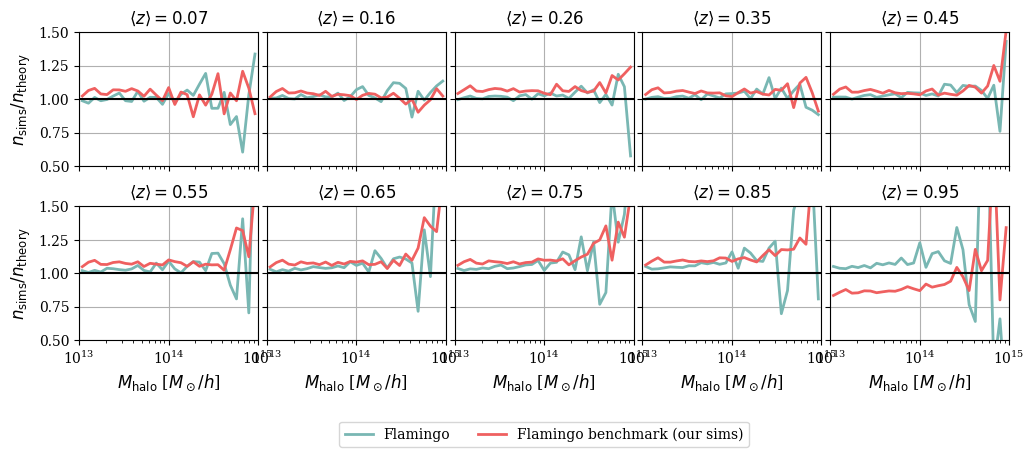

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from orphics import stats
import healpy as hp
import copy
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2=rgb_to_hex((239, 96, 96))
c_3=rgb_to_hex((255, 194, 0)) 
c_23=rgb_to_hex((121, 183, 179)) 
c_4=rgb_to_hex((30, 183, 179)) 
# Set font properties to match LaTeX document
plt.rcParams.update({
    "text.usetex": False,              # Use LaTeX for rendering text
    "font.family": "serif",           # Match LaTeX serif font
    "font.size": 12,                  # Match LaTeX default font size (modify accordingly)
    "axes.labelsize": 12,             # Font size for axis labels
    "axes.titlesize": 12,             # Font size for title
    "xtick.labelsize": 10,            # Font size for x-axis tick labels
    "ytick.labelsize": 10,            # Font size for y-axis tick labels
    "legend.fontsize": 10,            # Font size for legend
})

ncols = 5
n_bins = len(min_)
# Now we can plot without re-running anything
fig, ax = plt.subplots(2, n_bins // 2, figsize=(12, 4), sharex=True, sharey=True,
                       gridspec_kw={'wspace': 0.05, 'hspace': 0.3})



for i in frogress.bar(range(len(min_))):


    row = 1 if i >= ncols else 0
    col = i % ncols
    a = ax[row, col]

    a.plot(M_cen, M_ratios_flamingo[i], color=c_23, lw=2, linestyle='-', label='Flamingo')
    a.plot(M_cen, M_ratios_Gower[i] , color=c_2, lw=2, linestyle='-',  label= 'Flamingo benchmark (our sims)')

 
    a.set_xscale('log')
    a.axhline(1.0, color='black', linestyle='-')
    # a.axhline(0.9, color='black', linestyle='--')
    #a.axhline(1.1, color='black', linestyle='--')

   

    a.set_title(r"$\langle z \rangle = {:.2f}$".format(z_mean_[i]))
    a.tick_params(axis='both', which='major' )

    if row == 1:
        a.set_xlabel(r"$M_{\rm halo}$ [$M_\odot/h$]")
    if col == 0:
        a.set_ylabel(r"$n_{\rm sims} / n_{\rm theory}$")

    a.grid()
#ax[0, 0].legend(loc='lower left', frameon=True)
plt.legend(loc='lower center', bbox_to_anchor=(-1.6, -0.85), fontsize='small',ncol = 3)

plt.ylim([0.5,1.5])
plt.xlim([10**13,10**15.0])
plt.tight_layout()
plt.show()
